### This is a notebook to format your data for segmentation, run the images through the cloud instance of DeepCell, and then extract marker counts and morphological information from all the cells in your images

In [1]:
# import required packages
import os
import warnings

from ark.utils import data_utils, load_utils, io_utils, deepcell_service_utils, segmentation_utils
from ark.segmentation import marker_quantification

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

In [2]:
# set up file paths
base_dir = "../data/example_dataset"
input_dir = os.path.join(base_dir, "input_data")
tiff_dir = os.path.join(input_dir, "single_channel_inputs/")
deepcell_input_dir = os.path.join(input_dir, "deepcell_input/")
deepcell_output_dir = os.path.join(base_dir, 'deepcell_output')
single_cell_dir = os.path.join(base_dir, "single_cell_output")
label_dir = os.path.join(base_dir, 'deepcell_output')
viz_dir = os.path.join(base_dir, "deepcell_visualization")

# create directories if do not exist
for directory in [deepcell_input_dir, deepcell_output_dir, single_cell_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

### Here we are using the example data located in /data/example_dataset/input_data. To modify this notebook to run using your own data, simply change the base_dir to point to your own sub-directory within the data folder, rather than 'example_dataset'. 

In [3]:
# set this to true for multi-channel tiffs
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

# nuclear channel name(s) (or nucs = None)
nucs = ['HH3']

# membrane channel name(s) (or mems = None)
mems = ['Membrane']

# validate paths
io_utils.validate_paths([base_dir,
                         input_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         single_cell_dir
                         ])

### compute and filter fov paths

In [4]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

### load images into notebook, process, and save as deepcell compatable input

In [5]:
# load channels to be included in deepcell data
channels = (nucs if nucs else []) + (mems if mems else [])

# filter channels for None (just in case)
channels = [channel for channel in channels if channel is not None]

if MIBItiff:
    data_xr = load_utils.load_imgs_from_mibitiff(tiff_dir, mibitiff_files=fovs, channels=channels)
else:
    data_xr = load_utils.load_imgs_from_tree(tiff_dir, img_sub_folder="TIFs", fovs=fovs, channels=channels)

# generate and save deepcell input tifs
data_utils.generate_deepcell_input(data_xr, deepcell_input_dir, nucs, mems)

/Users/williamxu/PycharmProjects/ark-analysis/ark/utils/data_utils.py:39: UserWarning: ../data/example_dataset/input_data/deepcell_input/fov8.tif is a low contrast image
  io.imsave(save_path, out, plugin='tifffile')


## Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [6]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs)

[None]: Encountered RequestTransmissionFailed during UPLOAD ../data/example_dataset/input_data/deepcell_input/fovs.zip: [<twisted.python.failure.Failure OpenSSL.SSL.Error: [('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')]>]
Unexpected exception from treq.multipart.MultiPartProducer.stopProducing
Traceback (most recent call last):
  File "/Users/williamxu/opt/anaconda3/envs/ark_env/lib/python3.6/site-packages/twisted/protocols/policies.py", line 125, in connectionLost
    self.wrappedProtocol.connectionLost(reason)
  File "/Users/williamxu/opt/anaconda3/envs/ark_env/lib/python3.6/site-packages/twisted/web/_newclient.py", line 1050, in dispatcher
    return func(*args, **kwargs)
  File "/Users/williamxu/opt/anaconda3/envs/ark_env/lib/python3.6/site-packages/twisted/web/_newclient.py", line 1734, in _connectionLost_TRANSMITTING
    self._currentRequest.stopWriting()
  File "/Users/williamxu/opt/anaconda3/envs/ark_env/lib/python3.6/site-packages/twisted/web/

IndexError: list index out of range

### We can then load the segmented mask from deepcell via label-map TIFFs and save as an xarray

In [7]:
segmentation_labels = load_utils.load_imgs_from_dir(data_dir=label_dir,
                                                    imgdim_name='compartments',
                                                    image_name='whole_cell',
                                                    delimiter='_feature_0',
                                                    force_ints=True)


save_name = os.path.join(label_dir, 'segmentation_labels.xr')
if os.path.exists(save_name):
    print("overwriting previously generated processed output file")
    os.remove(save_name)

segmentation_labels.to_netcdf(save_name, format="NETCDF3_64BIT")

overwriting previously generated processed output file


### We can also then save the segmented mask overlaid on the imaging data

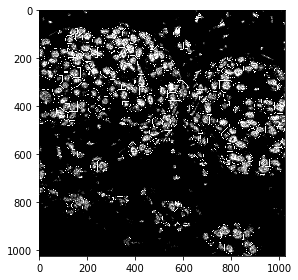

In [12]:
if fovs is None or fovs == []:
    fovs_input = io_utils.list_files(deepcell_input_dir, substrs=['tif'])
else:
    fovs_input = io_utils.list_files(deepcell_input_dir, substrs=fovs)

# Both channels and Point8

# Get input for overlay
input_data_xr = load_utils.load_imgs_from_multitiff(deepcell_input_dir,
                                                    multitiff_files=fovs_input)
# Overlaying the DNA
overlay_channels = input_data_xr.channels.values
warnings.simplefilter("ignore")

# Channel 0 and Point 8
segmentation_utils.visualize_segmentation(
            segmentation_labels_xr=segmentation_labels,
            fovs=input_data_xr[:,:,:,0].fovs.values, channel_data_xr=input_data_xr,
            chan_list = overlay_channels[0], output_dir=viz_dir, show=True)

chan_list = overlay_channels[0]

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [13]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each FOV given it's own folder and all FOVs having the same channels
combined_cell_size_normalized_data, combined_arcsinh_transformed_data = \
    marker_quantification.generate_cell_data(segmentation_labels=segmentation_labels,
                                             tiff_dir=tiff_dir,
                                             img_sub_folder="TIFs",
                                             is_mibitiff=MIBItiff,
                                             fovs=fovs,
                                             batch_size=5)

extracting data from fov8


In [14]:
# specify the path to the single_cell_output folder, and create it if it doesn't already exist
# this is where we will store our combined_normalized_data and combined_transformed_data output
single_cell_dir = os.path.join(base_dir, "single_cell_output")

if not os.path.exists(single_cell_dir):
    os.makedirs(single_cell_dir)

In [15]:
# specify the path to the single_cell_output folder, and create it if it doesn't already exist
# this is where we will store our combined_normalized_data and combined_transformed_data output
single_cell_dir = os.path.join(base_dir, "single_cell_output")

if not os.path.exists(single_cell_dir):
    os.makedirs(single_cell_dir)